Look at the relevance using coeficiente and then create new features
<br>
OBS: concatenate train and test when creating features
<br><br>
Label Enconding - transforms categorical data into numbers
<br>
BUT 'thinks' that the number changes the result, so only do for categories that depict intensity or so on.
<br>
BAD for linear models
GOOD for tree-based models
<br><br>
One Hot Encoding, transforms into 0 or 1, with various columns
<br>
BAD if you have too much categories

In [ ]:
# Look at the initial RMSE
print('RMSE before feature engineering:', get_kfold_rmse(train))

# Find the total area of the house
train['TotalArea'] = train['TotalBsmtSF'] + train['FirstFlrSF'] + train['SecondFlrSF']
print('RMSE with total area:', get_kfold_rmse(train))

# Find the area of the garden
train['GardenArea'] = train['LotArea'] - train['FirstFlrSF']
print('RMSE with garden area:', get_kfold_rmse(train))

# Find total number of bathrooms
train['TotalBath'] = train.FullBath + train.HalfBath
print('RMSE with number of bathrooms:', get_kfold_rmse(train))

In [ ]:
# Concatenate train and test together
taxi = pd.concat([train, test])

# Convert pickup date to datetime object
taxi['pickup_datetime'] = pd.to_datetime(taxi['pickup_datetime'])

# Create a day of week feature
taxi['dayofweek'] = taxi['pickup_datetime'].dt.dayofweek

# Create an hour feature
taxi['hour'] = taxi['pickup_datetime'].dt.hour

# Split back into train and test
new_train = taxi[taxi['id'].isin(train['id'])]
new_test = taxi[taxi['id'].isin(test['id'])]

In [ ]:
# Concatenate train and test together
houses = pd.concat([train, test])

# Label encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# Create new features
houses['RoofStyle_enc'] = le.fit_transform(houses.RoofStyle)
houses['CentralAir_enc'] = le.fit_transform(houses.CentralAir)

# Look at new features
print(houses[['RoofStyle', 'RoofStyle_enc', 'CentralAir', 'CentralAir_enc']].head())

In [ ]:
# Concatenate train and test together
houses = pd.concat([train, test])

# Label encode binary 'CentralAir' feature
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
houses['CentralAir_enc'] = le.fit_transform(houses['CentralAir'])

# Create One-Hot encoded features
ohe = pd.get_dummies(houses['RoofStyle'], prefix='RoofStyle')

# Concatenate OHE features to houses
houses = pd.concat([houses, ohe], axis=1)

# Look at OHE features
print(houses[[col for col in houses.columns if 'RoofStyle' in col]].head(3))

In [ ]:
def test_mean_target_encoding(train, test, target, categorical, alpha=5):
    # Calculate global mean on the train data
    global_mean = train[target].mean()
    
    # Group by the categorical feature and calculate its properties
    train_groups = train.groupby(categorical)
    category_sum = train_groups[target].sum()
    category_size = train_groups.size()
    
    # Calculate smoothed mean target statistics
    train_statistics = (category_sum + global_mean * alpha) / (category_size + alpha)
    
    # Apply statistics to the test data and fill new categories
    test_feature = test[categorical].map(train_statistics).fillna(global_mean)
    return test_feature.values

In [ ]:
def train_mean_target_encoding(train, target, categorical, alpha=5):
    # Create 5-fold cross-validation
    kf = KFold(n_splits=5, random_state=123, shuffle=True)
    train_feature = pd.Series(index=train.index)
    
    # For each folds split
    for train_index, test_index in kf.split(train):
        cv_train, cv_test = train.iloc[train_index], train.iloc[test_index]
      
        # Calculate out-of-fold statistics and apply to cv_test
        cv_test_feature = test_mean_target_encoding(cv_train, cv_test, target, categorical, alpha)
        
        # Save new feature for this particular fold
        train_feature.iloc[test_index] = cv_test_feature       
    return train_feature.values

In [ ]:
def mean_target_encoding(train, test, target, categorical, alpha=5):
  
    # Get the train feature
    train_feature = train_mean_target_encoding(train, target, categorical, alpha)
  
    # Get the test feature
    test_feature = test_mean_target_encoding(train, test, target, categorical, alpha)
    
    # Return new features to add to the model
    return train_feature, test_feature

In [ ]:
# Create 5-fold cross-validation
kf = KFold(n_splits=5, random_state=123, shuffle=True)

# For each folds split
for train_index, test_index in kf.split(bryant_shots):
    cv_train, cv_test = bryant_shots.iloc[train_index], bryant_shots.iloc[test_index]

    # Create mean target encoded feature
    cv_train['game_id_enc'], cv_test['game_id_enc'] = mean_target_encoding(train=cv_train,
                                                                           test= cv_test,
                                                                           target='shot_made_flag',
                                                                           categorical='game_id',
                                                                           alpha=5)
    # Look at the encoding
    print(cv_train[['game_id', 'shot_made_flag', 'game_id_enc']].sample(n=1))

Of course, binary classification is just a single special case. Target encoding could be applied to any target variable type:

For binary classification usually mean target encoding is used
For regression mean could be changed to median, quartiles, etc.
For multi-class classification with N classes we create N features with target mean for each category in one vs. all fashion

In [ ]:
# Create mean target encoded feature
train['RoofStyle_enc'], test['RoofStyle_enc'] = mean_target_encoding(train=train,
                                                                     test=test,
                                                                     target='SalePrice',
                                                                     categorical='RoofStyle',
                                                                     alpha=10)

# Look at the encoding
print(test[['RoofStyle', 'RoofStyle_enc']].drop_duplicates())



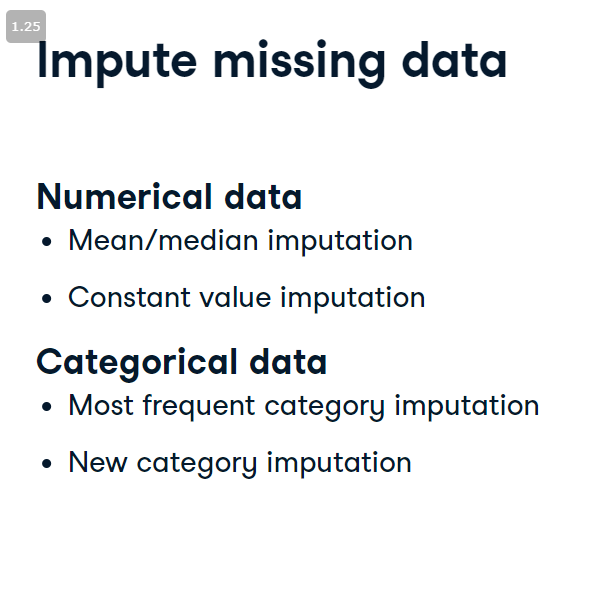

In [ ]:
# Read DataFrame
twosigma = pd.read_csv('twosigma_train.csv')

# Find the number of missing values in each column
print(twosigma.isnull().sum())

# Look at the columns with the missing values
print(twosigma[['price', 'building_id']].head())

In [ ]:
# Import SimpleImputer
from sklearn.impute import SimpleImputer

# Create constant imputer
constant_imputer = SimpleImputer(strategy= 'constant', fill_value='MISS')

# building_id imputation
rental_listings[['building_id']] = constant_imputer.fit_transform(rental_listings[['building_id']])